# Find Disconnected Components in Knowledge Graph

This notebook identifies all disconnected components (separate subgraphs) in your knowledge graph.

**What is a component?**
- A group of entities that are connected to each other
- But NOT connected to entities in other components
- Each component is a separate "island" in your graph

**Quick Start:**
1. Set your file path below
2. Run all cells

## Configuration

In [15]:
# Set this to your dataset file path
FILEPATH = "train.txt"  # ← CHANGE THIS!

## Import Libraries

In [16]:
from collections import defaultdict, deque, Counter
import pandas as pd

print("✓ Libraries imported")

✓ Libraries imported


## Step 1: Load the Graph

In [17]:
def load_graph(filepath):
    """Load graph data from file"""
    edges = []
    
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line and not line.startswith('#'):
                parts = line.split()
                if len(parts) >= 3:
                    source = parts[0]
                    relation = parts[1]
                    target = parts[2]
                    edges.append((source, relation, target))
    
    return edges

# Load the data
edges = load_graph(FILEPATH)
print(f"✓ Loaded {len(edges):,} edges")

✓ Loaded 13,821 edges


## Step 2: Build Undirected Graph

For component detection, we treat the graph as **undirected**.
This means if A → B exists, we also consider B → A.

In [18]:
def build_undirected_graph(edges):
    """Build an undirected adjacency list"""
    graph = defaultdict(set)
    all_entities = set()
    
    for source, relation, target in edges:
        # Add bidirectional edges (undirected)
        graph[source].add(target)
        graph[target].add(source)
        all_entities.add(source)
        all_entities.add(target)
    
    return graph, all_entities

graph, all_entities = build_undirected_graph(edges)
print(f"✓ Found {len(all_entities):,} unique entities")

✓ Found 1,316 unique entities


## Step 3: Find Components Using BFS

We use **Breadth-First Search (BFS)** to find all connected components.

In [19]:
def find_connected_components_bfs(graph, all_entities):
    """Find all connected components using BFS"""
    visited = set()
    components = []
    
    for start_entity in all_entities:
        if start_entity in visited:
            continue
        
        # BFS to find all entities in this component
        component = set()
        queue = deque([start_entity])
        
        while queue:
            entity = queue.popleft()
            
            if entity in visited:
                continue
            
            visited.add(entity)
            component.add(entity)
            
            # Add all neighbors to queue
            for neighbor in graph[entity]:
                if neighbor not in visited:
                    queue.append(neighbor)
        
        components.append(component)
    
    return components

print("Finding connected components...")
components = find_connected_components_bfs(graph, all_entities)
print(f"✓ Found {len(components):,} disconnected components")

Finding connected components...
✓ Found 50 disconnected components


## Step 4: Analyze Components

In [20]:
# Sort components by size (largest first)
components = sorted(components, key=len, reverse=True)

print("="*80)
print("CONNECTED COMPONENTS ANALYSIS")
print("="*80)
print(f"\nTotal number of disconnected components: {len(components):,}")
print(f"Largest component size: {len(components[0]):,} entities")
print(f"Smallest component size: {len(components[-1]):,} entities")

CONNECTED COMPONENTS ANALYSIS

Total number of disconnected components: 50
Largest component size: 27 entities
Smallest component size: 26 entities


## Component Size Distribution

In [21]:
# Size distribution
size_distribution = Counter([len(c) for c in components])

print("\nCOMPONENT SIZE DISTRIBUTION")
print("="*80)

dist_df = pd.DataFrame([
    {
        'Component Size': size,
        'Number of Components': count,
        'Percentage': f"{(count/len(components)*100):.2f}%"
    }
    for size, count in sorted(size_distribution.items(), reverse=True)
])

display(dist_df)


COMPONENT SIZE DISTRIBUTION


Component Size  Number of Components Percentage
0              27                    16     32.00%
1              26                    34     68.00%

## Visualize Component Sizes

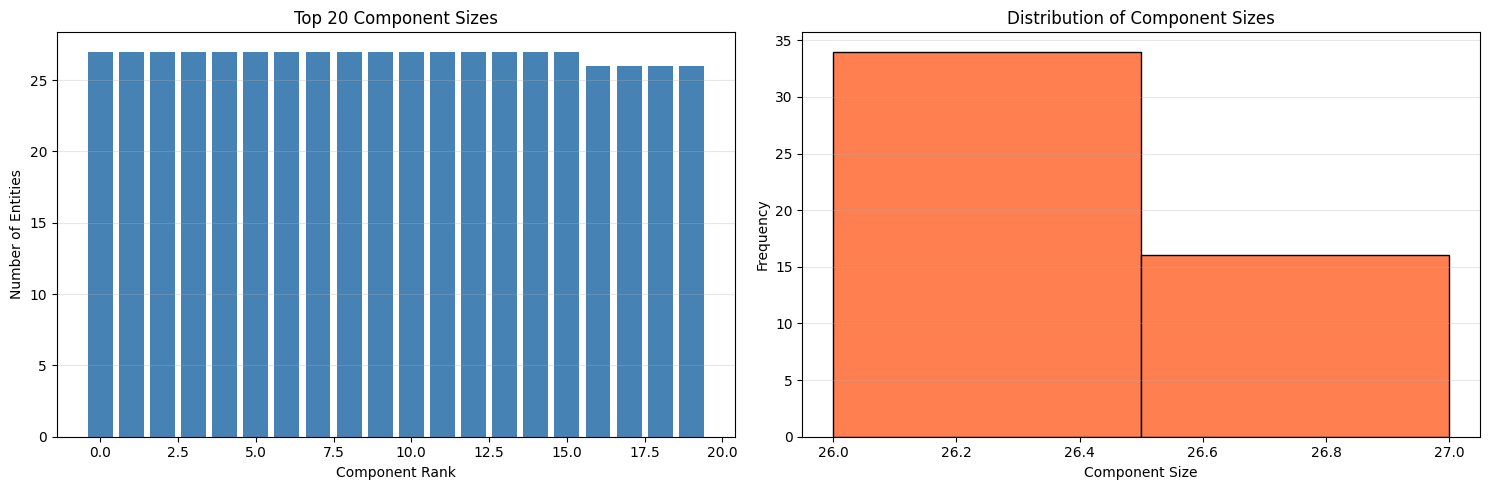

In [22]:
try:
    import matplotlib.pyplot as plt
    
    # Plot component sizes
    component_sizes = [len(c) for c in components]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Bar chart of top 20 components
    top_n = min(20, len(components))
    ax1.bar(range(top_n), component_sizes[:top_n], color='steelblue')
    ax1.set_xlabel('Component Rank')
    ax1.set_ylabel('Number of Entities')
    ax1.set_title(f'Top {top_n} Component Sizes')
    ax1.grid(axis='y', alpha=0.3)
    
    # Histogram of component sizes
    ax2.hist(component_sizes, bins=min(50, len(set(component_sizes))), color='coral', edgecolor='black')
    ax2.set_xlabel('Component Size')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of Component Sizes')
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
except ImportError:
    print("Install matplotlib for visualizations: pip install matplotlib")

## Detailed Component Information

Let's examine the top 10 largest components in detail.

In [24]:
num_to_show = min(10, len(components))

for i, component in enumerate(components[:num_to_show], 1):
    print("─"*80)
    print(f"Component #{i} - Size: {len(component):,} entities")
    print("─"*80)
    
    # Show sample entities
    sample_size = min(10, len(component))
    sample_entities = list(component)[:sample_size]
    
    print(f"Sample entities:")
    for j, entity in enumerate(sample_entities, 1):
        print(f"  {j:2d}. {entity}")
    
    if len(component) > sample_size:
        print(f"  ... and {len(component) - sample_size:,} more entities")
    
    # Find edges within this component
    component_edges = [
        (s, r, t) for s, r, t in edges 
        if s in component and t in component
    ]
    
    print(f"\nEdges within this component: {len(component_edges):,}")
    
    # Show relation types in this component
    relation_types = set(r for s, r, t in component_edges)
    print(f"Relation types: {len(relation_types)}")
    if relation_types:
        print(f"  {', '.join(sorted(relation_types)[:10])}")
    print()

if len(components) > num_to_show:
    print(f"... and {len(components) - num_to_show:,} more components")

────────────────────────────────────────────────────────────────────────────────
Component #1 - Size: 27 entities
────────────────────────────────────────────────────────────────────────────────
Sample entities:
   1. nico4
   2. vincent21
   3. moritz8
   4. fabian26
   5. jonas23
   6. paula12
   7. elias6
   8. dominik2
   9. natalie13
  10. ella19
  ... and 17 more entities

Edges within this component: 389
Relation types: 28
  auntOf, boyCousinOf, boyFirstCousinOnceRemovedOf, boySecondCousinOf, brotherOf, daughterOf, fatherOf, girlCousinOf, girlFirstCousinOnceRemovedOf, girlSecondCousinOf

────────────────────────────────────────────────────────────────────────────────
Component #2 - Size: 27 entities
────────────────────────────────────────────────────────────────────────────────
Sample entities:
   1. beate134
   2. clara144
   3. alina156
   4. laura143
   5. marcel154
   6. larissa136
   7. vanessa141
   8. gabriel146
   9. alexander137
  10. johanna131
  ... and 17 more entit

## Find Isolated Entities

Isolated entities are components with only 1 entity (no connections).

In [25]:
isolated_entities = [c for c in components if len(c) == 1]

print("="*80)
print("ISOLATED ENTITIES")
print("="*80)
print(f"\nNumber of isolated entities: {len(isolated_entities):,}")

if isolated_entities and len(isolated_entities) <= 20:
    print(f"\nList of isolated entities:")
    for i, component in enumerate(isolated_entities, 1):
        entity = list(component)[0]
        print(f"  {i:2d}. {entity}")
elif len(isolated_entities) > 20:
    print(f"\nFirst 20 isolated entities:")
    for i, component in enumerate(isolated_entities[:20], 1):
        entity = list(component)[0]
        print(f"  {i:2d}. {entity}")
    print(f"  ... and {len(isolated_entities) - 20:,} more")

ISOLATED ENTITIES

Number of isolated entities: 0


## Create DataFrame of All Components

In [26]:
# Create a DataFrame with component information
component_data = []

for i, component in enumerate(components, 1):
    for entity in component:
        component_data.append({
            'Component_ID': i,
            'Component_Size': len(component),
            'Entity': entity
        })

df_components = pd.DataFrame(component_data)

print(f"✓ Created DataFrame with {len(df_components):,} rows")
print(f"\nFirst 10 rows:")
display(df_components.head(10))

✓ Created DataFrame with 1,316 rows

First 10 rows:


Component_ID  Component_Size     Entity
0             1              27      nico4
1             1              27  vincent21
2             1              27    moritz8
3             1              27   fabian26
4             1              27    jonas23
5             1              27    paula12
6             1              27     elias6
7             1              27   dominik2
8             1              27  natalie13
9             1              27     ella19

## Summary Statistics

In [27]:
print("="*80)
print("SUMMARY")
print("="*80)
print(f"\nTotal entities: {len(all_entities):,}")
print(f"Total edges: {len(edges):,}")
print(f"Disconnected components: {len(components):,}")
print(f"\nLargest component: {len(components[0]):,} entities ({len(components[0])/len(all_entities)*100:.1f}%)")
print(f"Smallest component: {len(components[-1]):,} entities")
print(f"Isolated entities: {len(isolated_entities):,}")

if len(components) > 1:
    print(f"\n⚠ Your graph has {len(components):,} disconnected parts!")
    print(f"  The largest component contains {len(components[0])/len(all_entities)*100:.1f}% of all entities.")
else:
    print(f"\n✓ Your graph is fully connected (single component)!")

print("="*80)

SUMMARY

Total entities: 1,316
Total edges: 13,821
Disconnected components: 50

Largest component: 27 entities (2.1%)
Smallest component: 26 entities
Isolated entities: 0

⚠ Your graph has 50 disconnected parts!
  The largest component contains 2.1% of all entities.


## Export Results

In [28]:
# Save to CSV
df_components.to_csv('components.csv', index=False)
print("✓ Saved components to 'components.csv'")

# Save component summary
summary_df = pd.DataFrame([
    {
        'Component_ID': i,
        'Size': len(component),
        'Percentage_of_Total': f"{len(component)/len(all_entities)*100:.2f}%"
    }
    for i, component in enumerate(components, 1)
])

summary_df.to_csv('component_summary.csv', index=False)
print("✓ Saved component summary to 'component_summary.csv'")

✓ Saved components to 'components.csv'
✓ Saved component summary to 'component_summary.csv'


## Explore Specific Component

Enter a component ID to explore it in detail:

In [29]:
# Choose which component to explore (change this number)
COMPONENT_ID = 1  # ← Change this to explore different components

if 1 <= COMPONENT_ID <= len(components):
    component = components[COMPONENT_ID - 1]
    
    print(f"Component #{COMPONENT_ID}")
    print("="*80)
    print(f"Size: {len(component):,} entities")
    
    print(f"\nAll entities in this component:")
    for i, entity in enumerate(sorted(component), 1):
        print(f"  {i:3d}. {entity}")
    
    # Show all edges within this component
    component_edges = [
        (s, r, t) for s, r, t in edges 
        if s in component and t in component
    ]
    
    print(f"\nEdges in this component: {len(component_edges):,}")
    if component_edges:
        edge_df = pd.DataFrame(component_edges, columns=['Source', 'Relation', 'Target'])
        display(edge_df.head(20))
else:
    print(f"Invalid component ID. Choose between 1 and {len(components)}")

Component #1
Size: 27 entities

All entities in this component:
    1. adam9
    2. david20
    3. dominik2
    4. elias6
    5. ella19
    6. emily15
    7. emma7
    8. fabian26
    9. isabella11
   10. johanna22
   11. jonas23
   12. katharina1
   13. lena18
   14. leon16
   15. lisa5
   16. luis14
   17. mia17
   18. moritz8
   19. natalie13
   20. nico4
   21. oliver3
   22. olivia0
   23. oskar24
   24. paula12
   25. selina10
   26. valentina25
   27. vincent21

Edges in this component: 389


Source         Relation      Target
0   olivia0         sisterOf    selina10
1   olivia0         sisterOf  isabella11
2   olivia0         sisterOf     oskar24
3   olivia0         sisterOf       adam9
4   olivia0     secondAuntOf      lena18
5   olivia0     secondAuntOf    fabian26
6   olivia0     girlCousinOf      leon16
7   olivia0     girlCousinOf   johanna22
8   olivia0     girlCousinOf     jonas23
9   olivia0       daughterOf  katharina1
10  olivia0       daughterOf    dominik2
11  olivia0  granddaughterOf      ella19
12  olivia0  granddaughterOf     david20
13  olivia0  granddaughterOf       emma7
14  olivia0  granddaughterOf     moritz8
15  olivia0          nieceOf     paula12
16  olivia0          nieceOf   natalie13
17  olivia0          nieceOf      luis14
18  olivia0         motherOf       lisa5
19  olivia0         motherOf      elias6

# VISUALIZATION OF COMPONENTS

Now let's visualize all the components to see their structure!

## Install NetworkX (if needed)

NetworkX is required for graph visualization. Run this cell to install it:

In [31]:
# Uncomment and run if you need to install NetworkX
# !pip install networkx matplotlib

try:
    import networkx as nx
    import matplotlib.pyplot as plt
    print("✓ NetworkX and Matplotlib are installed")
    VISUALIZATION_AVAILABLE = True
except ImportError:
    print("❌ Please install: pip install networkx matplotlib")
    VISUALIZATION_AVAILABLE = False

✓ NetworkX and Matplotlib are installed


## Method 1: Visualize All Components (Grid Layout)

This shows all components in a grid, with each component as a separate subplot.

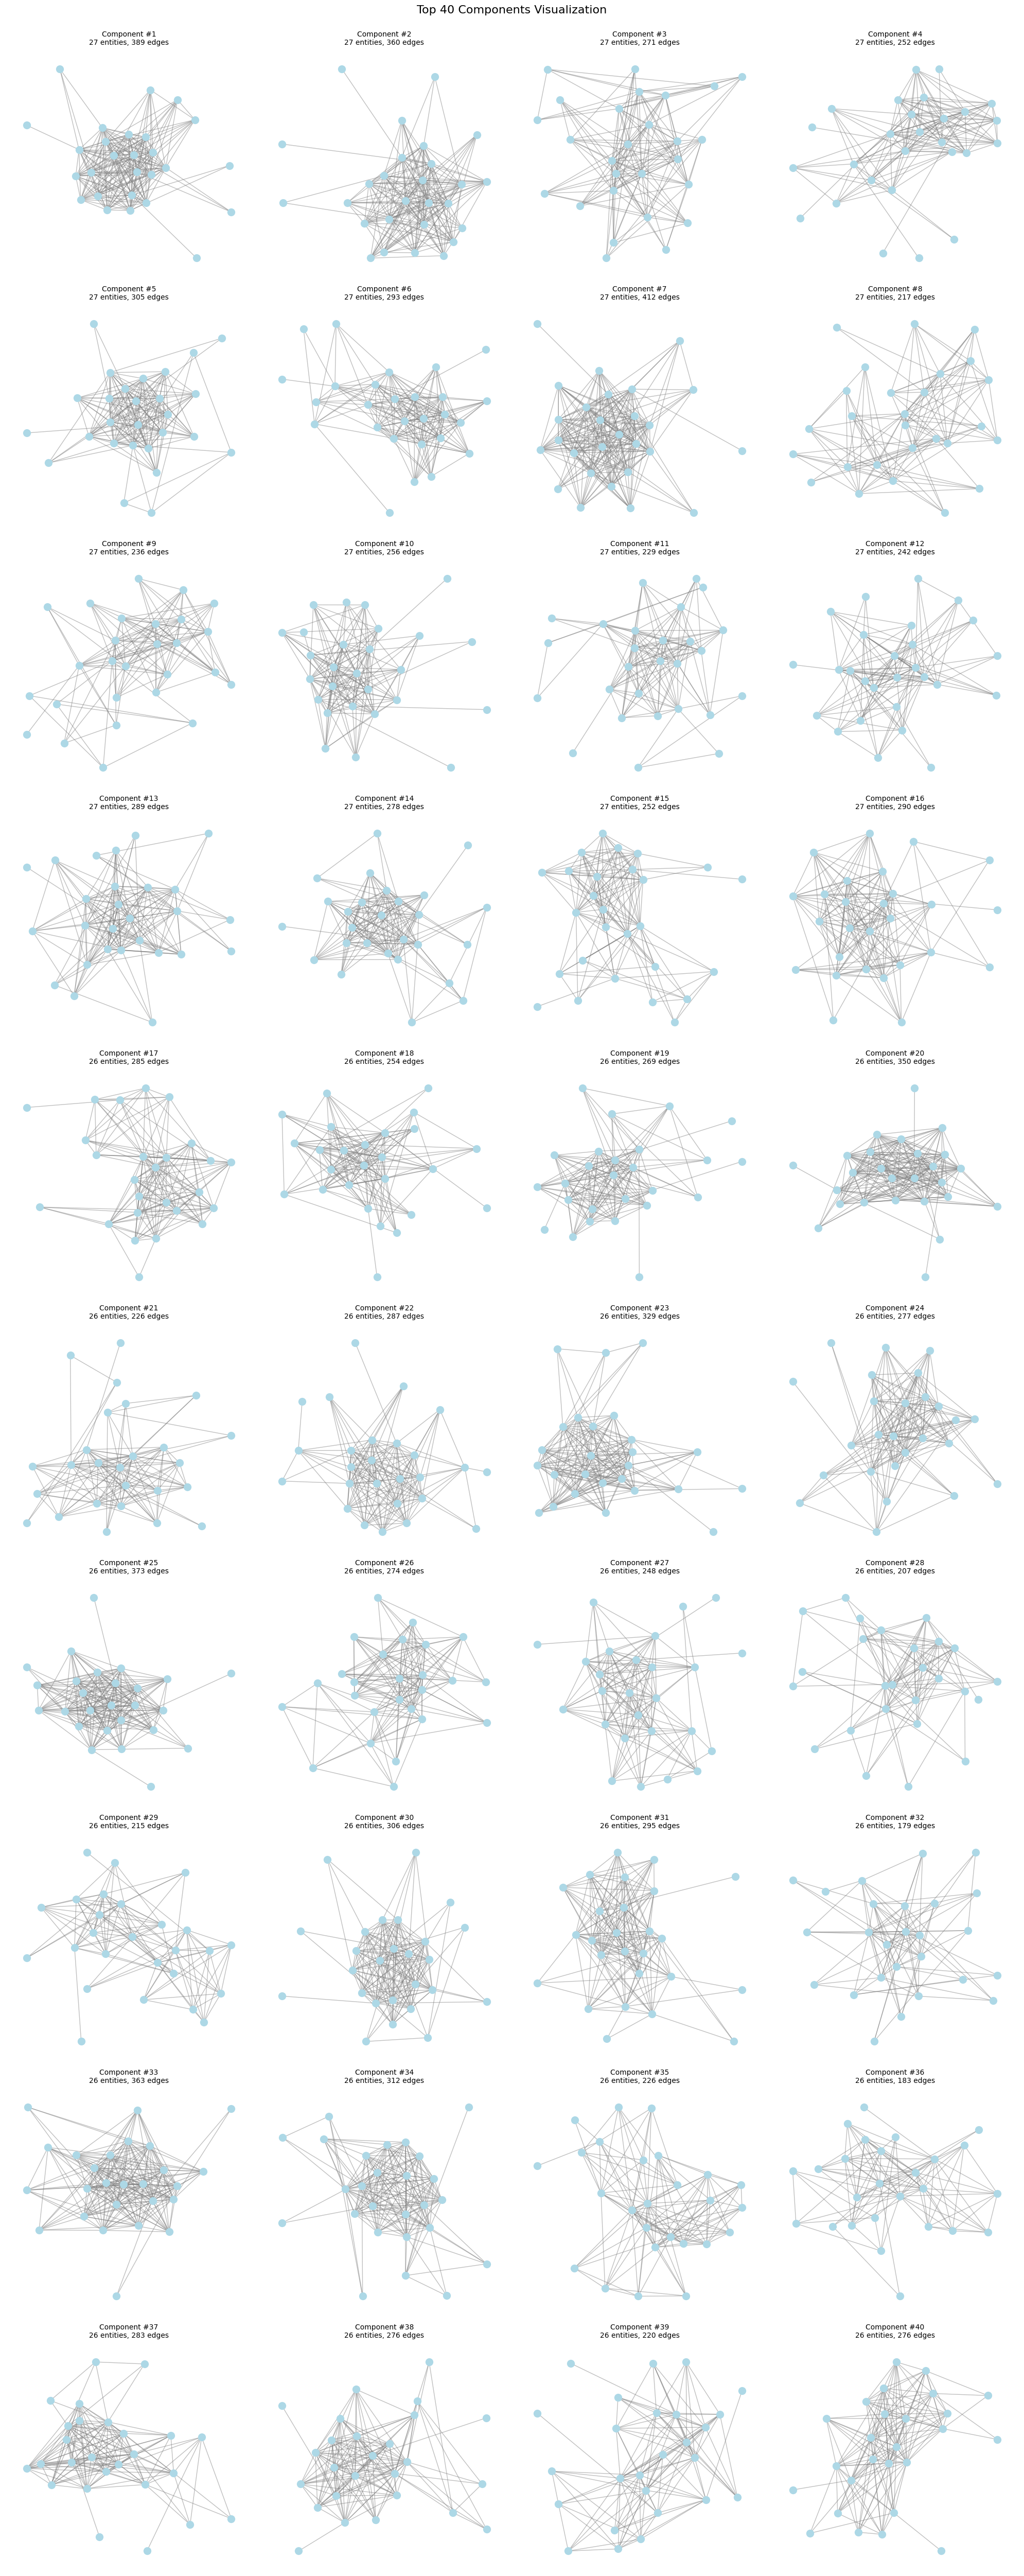


Showing top 40 components.
Total components: 50


In [37]:
if VISUALIZATION_AVAILABLE:
    # Configuration
    MAX_COMPONENTS_TO_SHOW = 40  # Limit to avoid overwhelming display
    
    components_to_plot = min(MAX_COMPONENTS_TO_SHOW, len(components))
    
    # Calculate grid dimensions
    cols = 4
    rows = (components_to_plot + cols - 1) // cols
    
    # Create figure
    fig, axes = plt.subplots(rows, cols, figsize=(20, 5*rows))
    fig.suptitle(f'Top {components_to_plot} Components Visualization', fontsize=16, y=1.00)
    
    # Flatten axes for easier iteration
    if components_to_plot == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if components_to_plot > cols else [axes] if components_to_plot == 1 else axes
    
    # Plot each component
    for idx, component in enumerate(components[:components_to_plot]):
        ax = axes[idx] if components_to_plot > 1 else axes[0]
        
        # Create subgraph for this component
        G = nx.Graph()
        
        # Add edges within this component
        component_edges = [
            (s, t) for s, r, t in edges 
            if s in component and t in component
        ]
        
        G.add_edges_from(component_edges)
        
        # Choose layout based on component size
        if len(component) <= 10:
            pos = nx.spring_layout(G, k=2, iterations=50)
        elif len(component) <= 50:
            pos = nx.spring_layout(G, k=1, iterations=30)
        else:
            pos = nx.spring_layout(G, k=0.5, iterations=20)
        
        # Draw the graph
        nx.draw_networkx_nodes(G, pos, 
                              node_color='lightblue', 
                              node_size=300 if len(component) <= 20 else 100,
                              ax=ax)
        
        nx.draw_networkx_edges(G, pos, 
                              edge_color='gray', 
                              alpha=0.5,
                              ax=ax)
        
        # Add labels only for small components
        if len(component) <= 15:
            nx.draw_networkx_labels(G, pos, 
                                   font_size=8,
                                   ax=ax)
        
        ax.set_title(f'Component #{idx+1}\n{len(component)} entities, {len(component_edges)} edges', 
                    fontsize=10)
        ax.axis('off')
    
    # Hide empty subplots
    for idx in range(components_to_plot, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    if len(components) > MAX_COMPONENTS_TO_SHOW:
        print(f"\nShowing top {MAX_COMPONENTS_TO_SHOW} components.")
        print(f"Total components: {len(components)}")

## Method 2: Visualize Individual Component (Large & Detailed)

Choose a specific component to visualize in detail with labels.

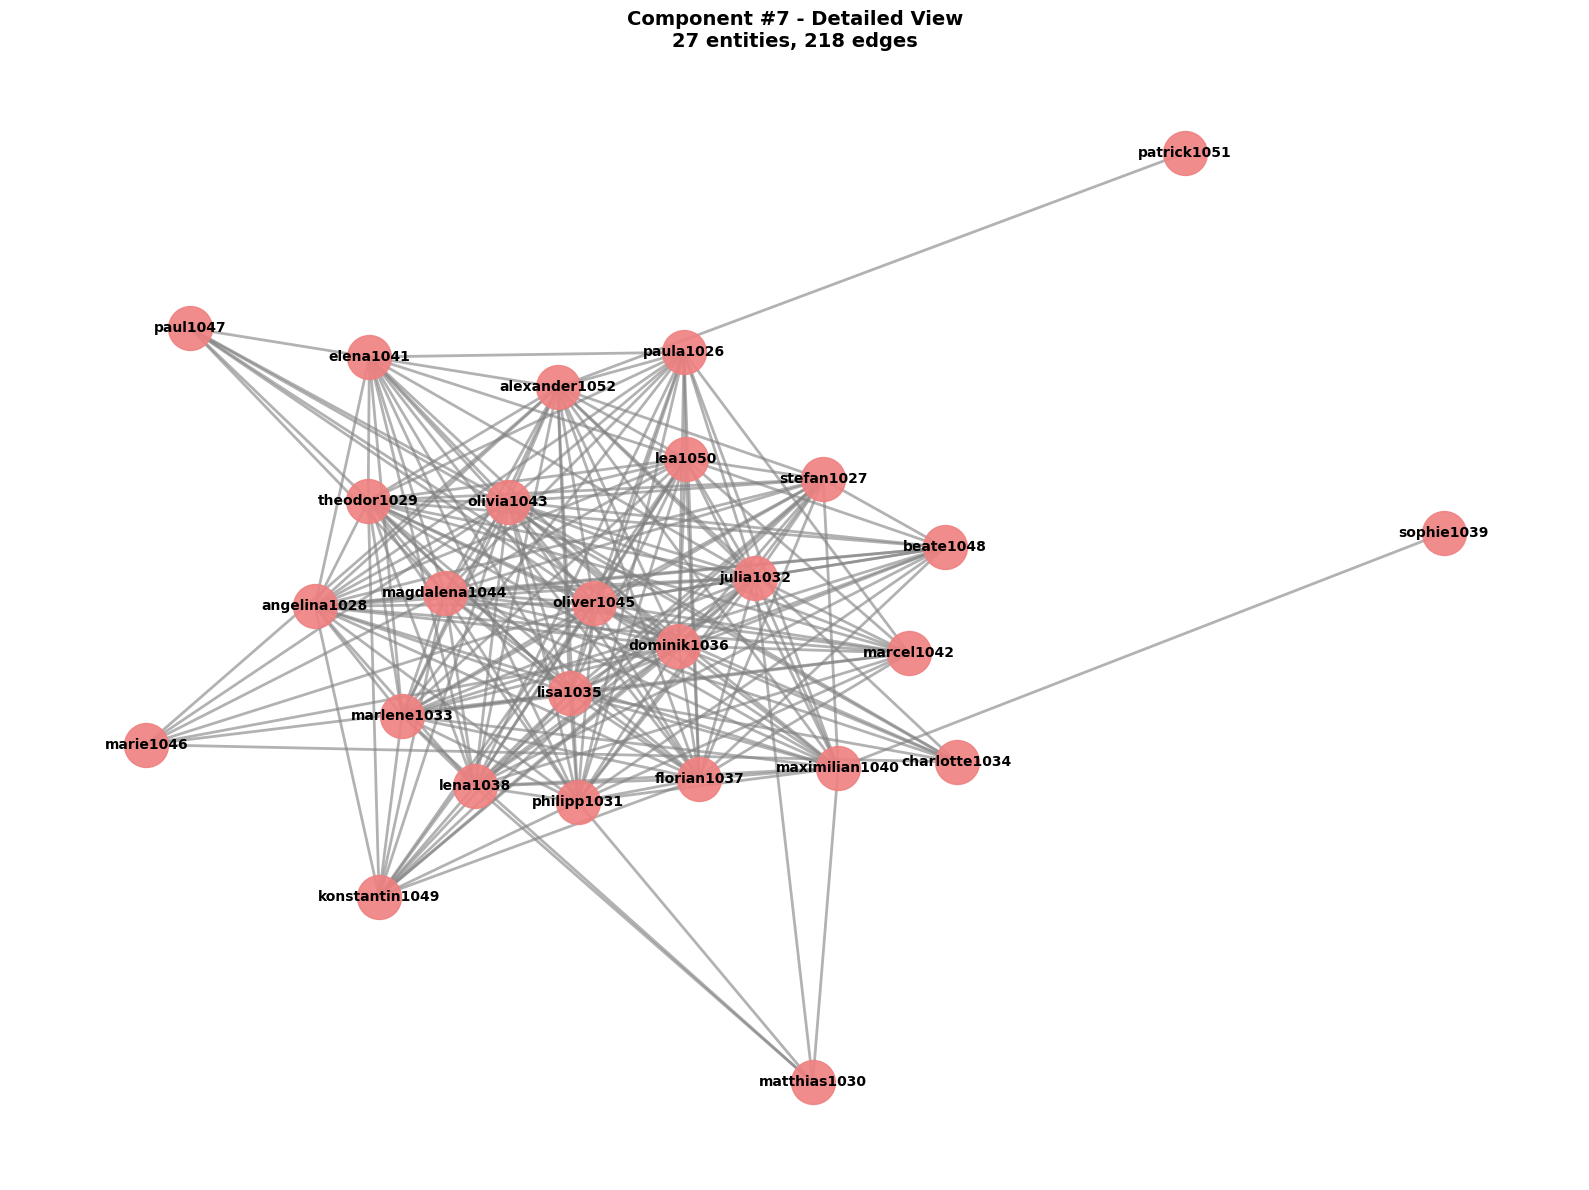


Component #7 Statistics:
  Nodes: 27
  Edges: 218
  Density: 0.6211
  Average degree: 16.15


In [39]:
if VISUALIZATION_AVAILABLE:
    # Choose component to visualize (change this!)
    COMPONENT_TO_VISUALIZE = 7  # ← Change this number
    
    if 1 <= COMPONENT_TO_VISUALIZE <= len(components):
        component = components[COMPONENT_TO_VISUALIZE - 1]
        
        # Create graph for this component
        G = nx.Graph()
        
        # Add edges with relation labels
        edge_labels = {}
        for s, r, t in edges:
            if s in component and t in component:
                G.add_edge(s, t)
                if (s, t) not in edge_labels:
                    edge_labels[(s, t)] = r
        
        # Create figure
        plt.figure(figsize=(16, 12))
        
        # Choose layout
        if len(component) <= 30:
            pos = nx.spring_layout(G, k=3, iterations=100, seed=42)
        elif len(component) <= 100:
            pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
        else:
            pos = nx.spring_layout(G, k=1, iterations=30, seed=42)
        
        # Draw nodes
        nx.draw_networkx_nodes(G, pos, 
                              node_color='lightcoral',
                              node_size=1000 if len(component) <= 30 else 500,
                              alpha=0.9)
        
        # Draw edges
        nx.draw_networkx_edges(G, pos, 
                              edge_color='gray',
                              width=2,
                              alpha=0.6)
        
        # Draw labels
        if len(component) <= 50:
            nx.draw_networkx_labels(G, pos, 
                                   font_size=10 if len(component) <= 30 else 8,
                                   font_weight='bold')
        
        # Draw edge labels (only for small components)
        if len(component) <= 20:
            nx.draw_networkx_edge_labels(G, pos, 
                                        edge_labels=edge_labels,
                                        font_size=8,
                                        font_color='darkgreen')
        
        plt.title(f'Component #{COMPONENT_TO_VISUALIZE} - Detailed View\n'
                 f'{len(component)} entities, {G.number_of_edges()} edges',
                 fontsize=14, fontweight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        # Print statistics
        print(f"\nComponent #{COMPONENT_TO_VISUALIZE} Statistics:")
        print(f"  Nodes: {G.number_of_nodes()}")
        print(f"  Edges: {G.number_of_edges()}")
        print(f"  Density: {nx.density(G):.4f}")
        print(f"  Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")
    else:
        print(f"Invalid component number. Choose between 1 and {len(components)}")

## Method 3: Interactive Component Selector

Visualize multiple components side-by-side for comparison.

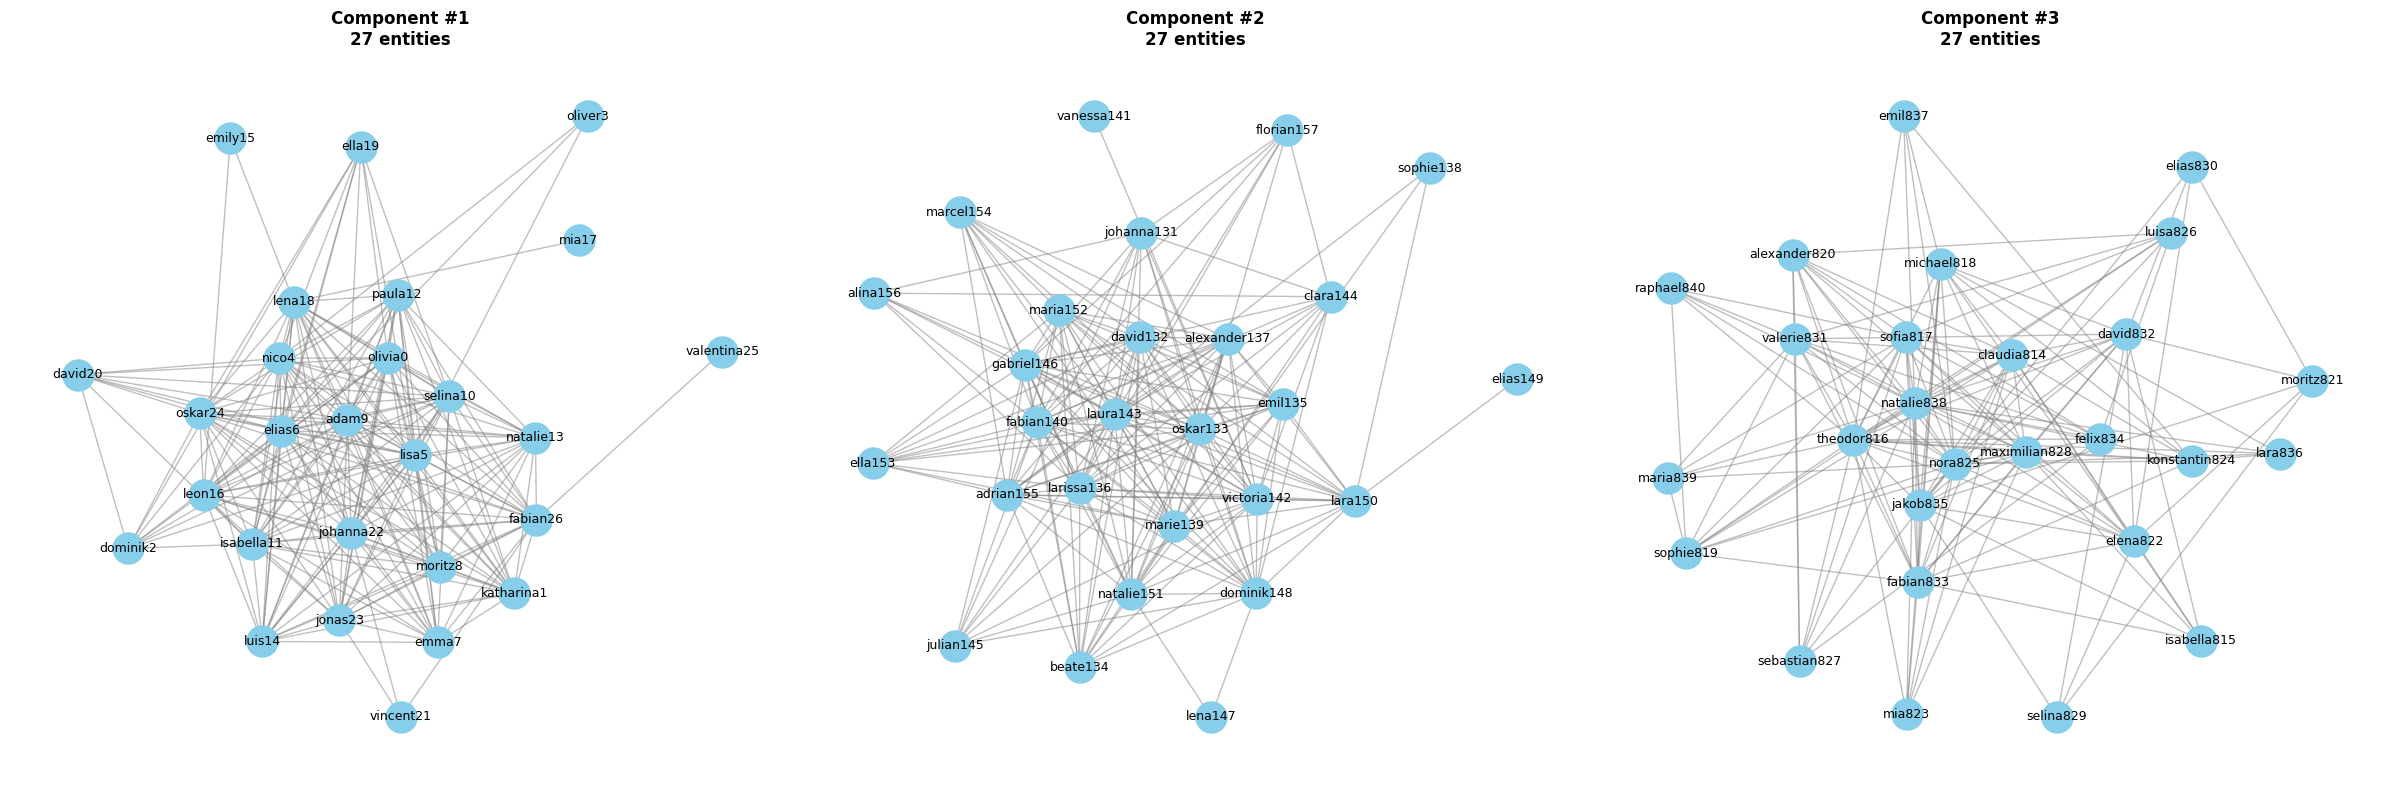

In [34]:
if VISUALIZATION_AVAILABLE:
    # Select which components to compare (change these!)
    COMPONENTS_TO_COMPARE = [1, 2, 3]  # ← Change these numbers
    
    valid_components = [c for c in COMPONENTS_TO_COMPARE if 1 <= c <= len(components)]
    
    if valid_components:
        n_comps = len(valid_components)
        fig, axes = plt.subplots(1, n_comps, figsize=(8*n_comps, 8))
        
        if n_comps == 1:
            axes = [axes]
        
        for idx, comp_id in enumerate(valid_components):
            component = components[comp_id - 1]
            ax = axes[idx]
            
            # Create graph
            G = nx.Graph()
            component_edges = [
                (s, t) for s, r, t in edges 
                if s in component and t in component
            ]
            G.add_edges_from(component_edges)
            
            # Layout
            pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
            
            # Draw
            nx.draw_networkx_nodes(G, pos,
                                  node_color='skyblue',
                                  node_size=500,
                                  ax=ax)
            
            nx.draw_networkx_edges(G, pos,
                                  edge_color='gray',
                                  alpha=0.5,
                                  ax=ax)
            
            if len(component) <= 30:
                nx.draw_networkx_labels(G, pos, font_size=9, ax=ax)
            
            ax.set_title(f'Component #{comp_id}\n{len(component)} entities',
                        fontsize=12, fontweight='bold')
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"No valid components selected. Choose from 1 to {len(components)}")

## Method 4: Combined Visualization (All Components in One)

Shows all components in a single plot with different colors for each component.

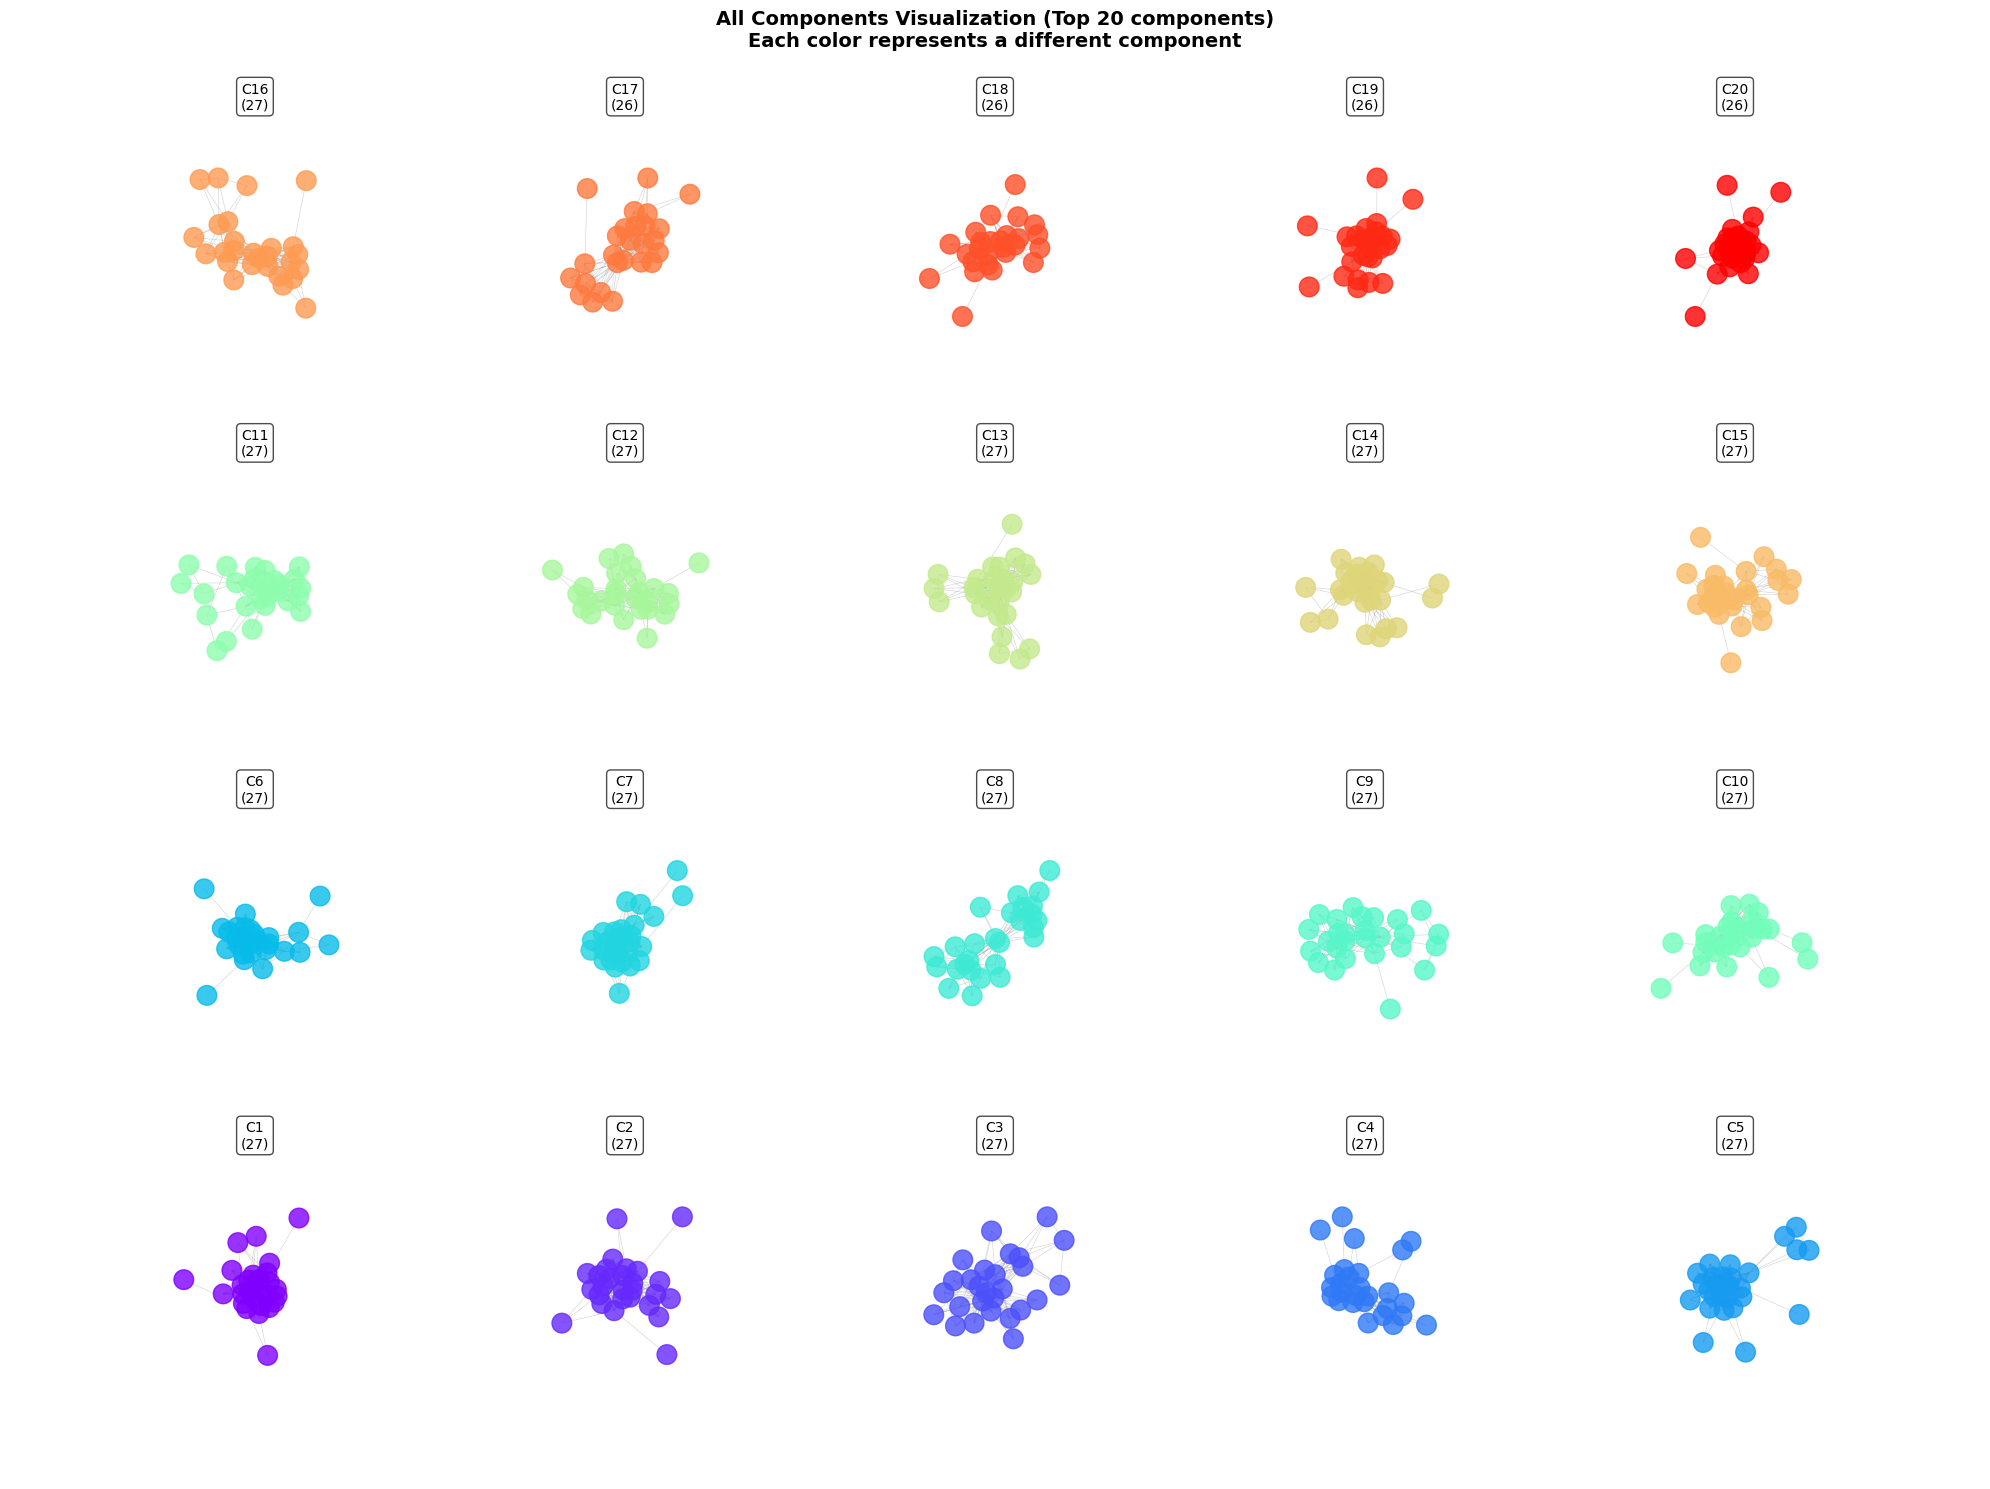


Showing top 20 components out of 50 total.


In [35]:
if VISUALIZATION_AVAILABLE:
    import matplotlib.cm as cm
    import numpy as np
    
    # Limit number of components to visualize
    MAX_COMPONENTS = 20
    components_to_show = components[:MAX_COMPONENTS]
    
    # Create full graph
    G = nx.Graph()
    
    # Add all edges from selected components
    entity_to_component = {}
    for comp_idx, component in enumerate(components_to_show):
        for entity in component:
            entity_to_component[entity] = comp_idx
        
        component_edges = [
            (s, t) for s, r, t in edges 
            if s in component and t in component
        ]
        G.add_edges_from(component_edges)
    
    # Create color map
    colors = cm.rainbow(np.linspace(0, 1, len(components_to_show)))
    node_colors = [colors[entity_to_component[node]] for node in G.nodes()]
    
    # Layout - position components separately
    pos = {}
    component_positions = []
    
    # Calculate positions for each component
    n_comps = len(components_to_show)
    cols = int(np.ceil(np.sqrt(n_comps)))
    rows = int(np.ceil(n_comps / cols))
    
    for idx, component in enumerate(components_to_show):
        # Create subgraph for this component
        subgraph = G.subgraph(component)
        
        # Layout for this component
        if len(component) > 0:
            sub_pos = nx.spring_layout(subgraph, k=0.5, iterations=30)
            
            # Offset to grid position
            row = idx // cols
            col = idx % cols
            offset_x = col * 5
            offset_y = row * 5
            
            for node, (x, y) in sub_pos.items():
                pos[node] = (x + offset_x, y + offset_y)
    
    # Create figure
    plt.figure(figsize=(20, 15))
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos,
                          node_color=node_colors,
                          node_size=200,
                          alpha=0.8)
    
    # Draw edges
    nx.draw_networkx_edges(G, pos,
                          edge_color='gray',
                          alpha=0.3,
                          width=0.5)
    
    # Add component labels
    for idx, component in enumerate(components_to_show):
        row = idx // cols
        col = idx % cols
        offset_x = col * 5
        offset_y = row * 5
        
        plt.text(offset_x, offset_y + 2, 
                f'C{idx+1}\n({len(component)})',
                fontsize=10,
                ha='center',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    plt.title(f'All Components Visualization (Top {len(components_to_show)} components)\n'
             f'Each color represents a different component',
             fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    if len(components) > MAX_COMPONENTS:
        print(f"\nShowing top {MAX_COMPONENTS} components out of {len(components)} total.")

## Method 5: Size-Based Visualization

Visualize only components within a certain size range.

Found 50 components with size between 2 and 50


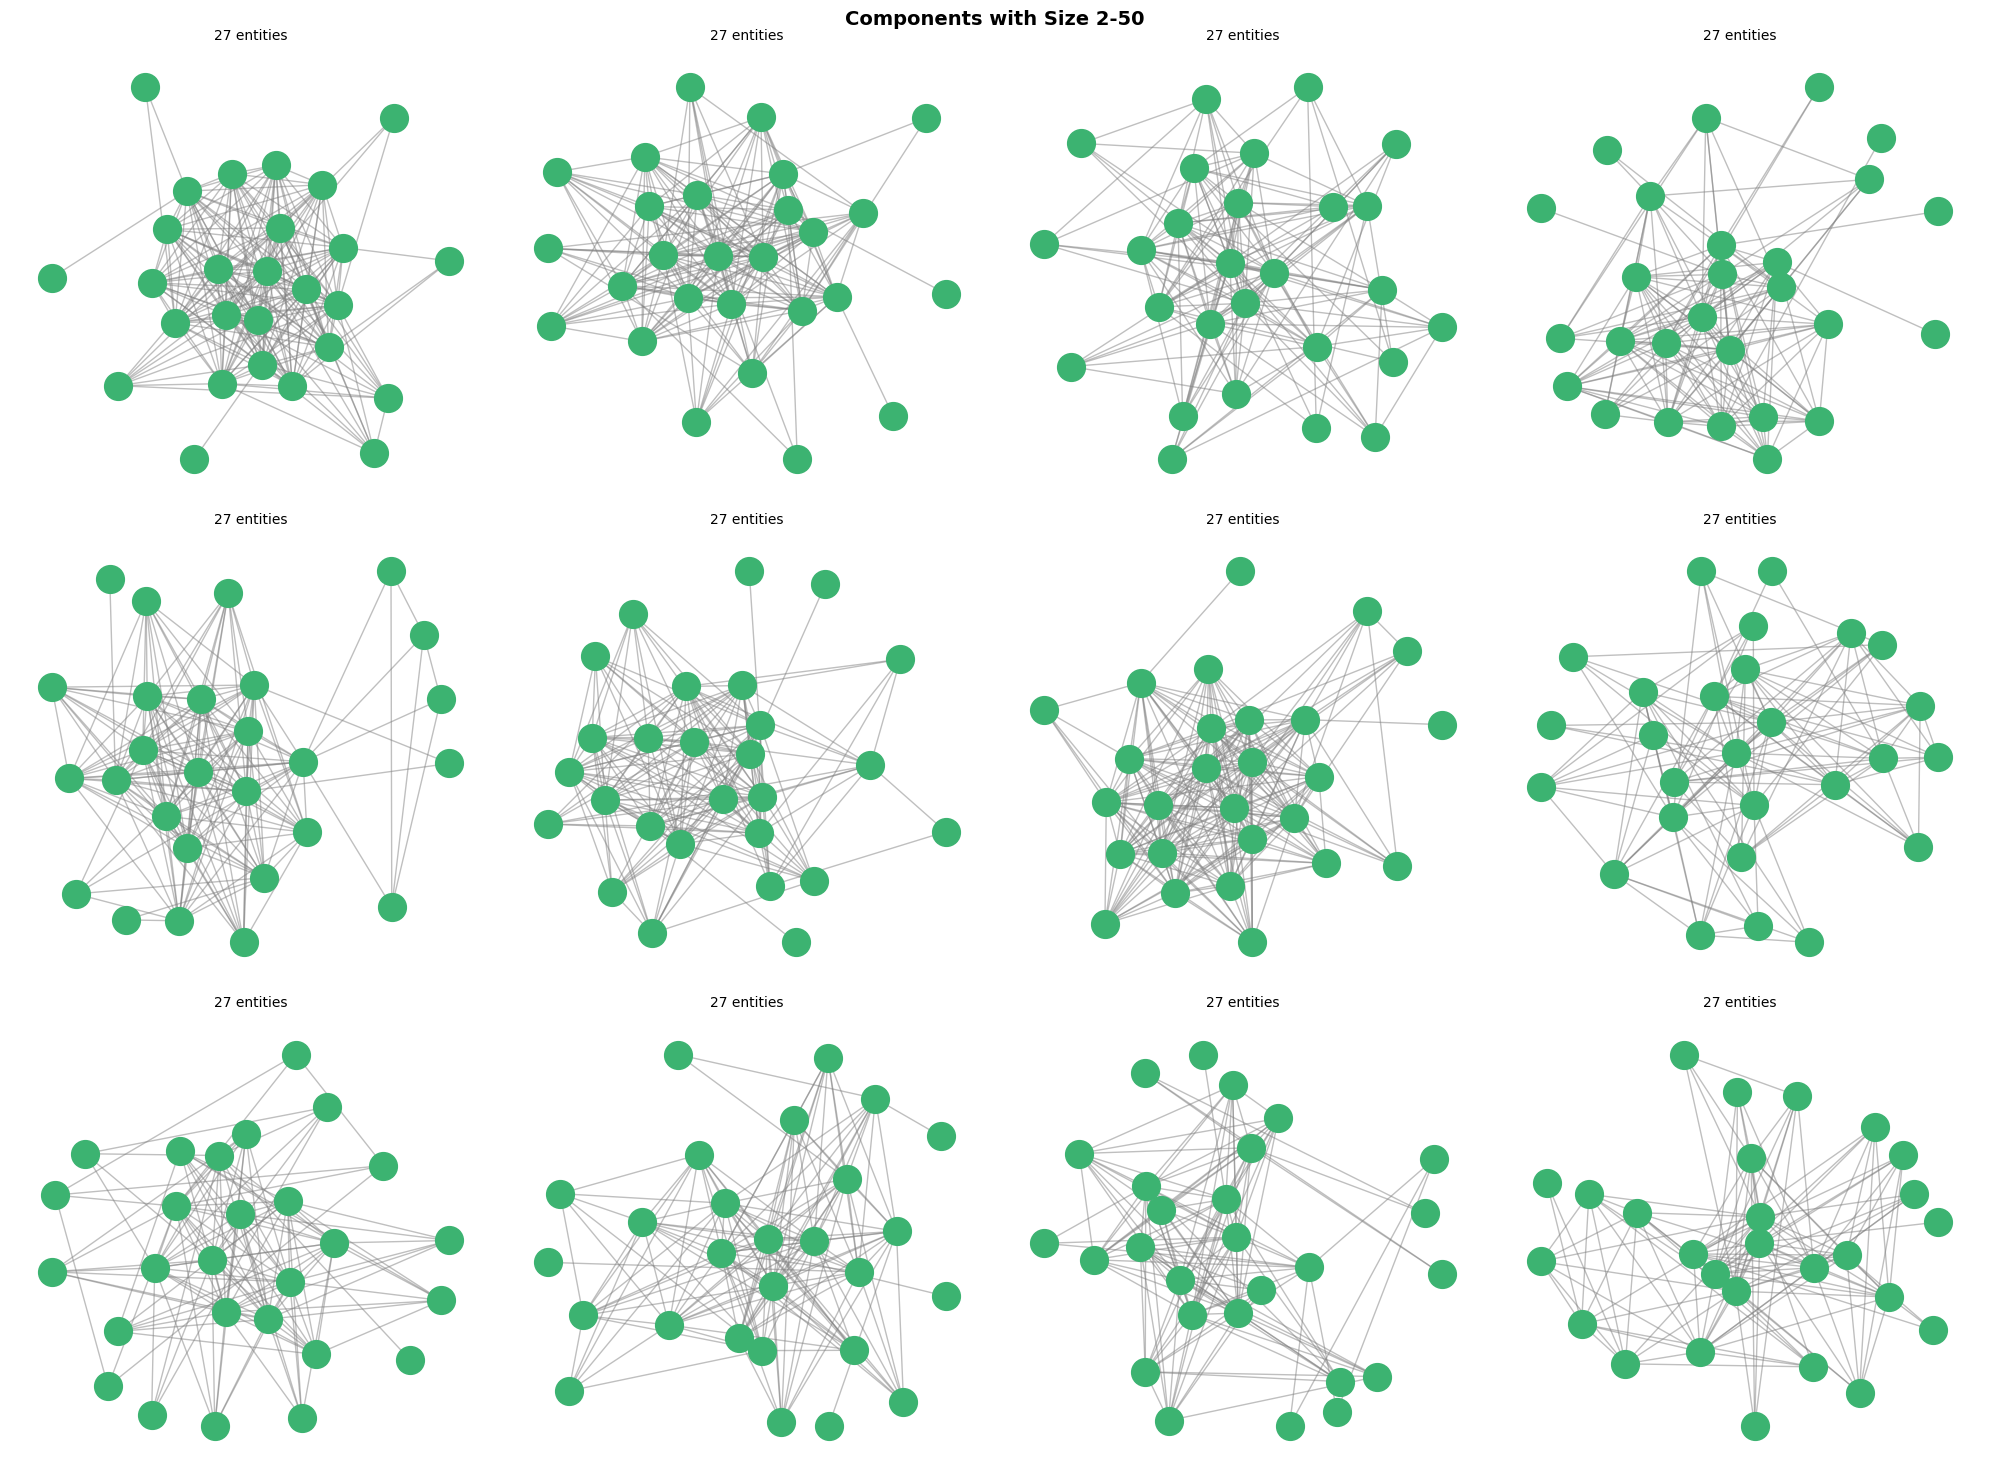

In [36]:
if VISUALIZATION_AVAILABLE:
    # Filter components by size
    MIN_SIZE = 2   # ← Minimum component size to show
    MAX_SIZE = 50  # ← Maximum component size to show
    
    filtered_components = [
        c for c in components 
        if MIN_SIZE <= len(c) <= MAX_SIZE
    ]
    
    print(f"Found {len(filtered_components)} components with size between {MIN_SIZE} and {MAX_SIZE}")
    
    if filtered_components:
        # Show up to 12 components
        to_show = min(12, len(filtered_components))
        
        cols = 4
        rows = (to_show + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(20, 5*rows))
        axes = axes.flatten() if to_show > 1 else [axes]
        
        for idx, component in enumerate(filtered_components[:to_show]):
            ax = axes[idx]
            
            # Create graph
            G = nx.Graph()
            component_edges = [
                (s, t) for s, r, t in edges 
                if s in component and t in component
            ]
            G.add_edges_from(component_edges)
            
            # Layout and draw
            pos = nx.spring_layout(G, k=2, iterations=50)
            
            nx.draw_networkx_nodes(G, pos, node_color='mediumseagreen', 
                                  node_size=400, ax=ax)
            nx.draw_networkx_edges(G, pos, edge_color='gray', 
                                  alpha=0.5, ax=ax)
            
            if len(component) <= 20:
                nx.draw_networkx_labels(G, pos, font_size=8, ax=ax)
            
            ax.set_title(f'{len(component)} entities', fontsize=10)
            ax.axis('off')
        
        # Hide empty subplots
        for idx in range(to_show, len(axes)):
            axes[idx].axis('off')
        
        plt.suptitle(f'Components with Size {MIN_SIZE}-{MAX_SIZE}', 
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    else:
        print(f"No components found in size range {MIN_SIZE}-{MAX_SIZE}")

## Save Visualizations to Files

In [ ]:
if VISUALIZATION_AVAILABLE:
    print("Saving visualizations to files...\n")
    
    # Save top 10 components
    components_to_save = min(10, len(components))
    
    for idx, component in enumerate(components[:components_to_save], 1):
        # Create graph
        G = nx.Graph()
        component_edges = [
            (s, t) for s, r, t in edges 
            if s in component and t in component
        ]
        G.add_edges_from(component_edges)
        
        # Create figure
        plt.figure(figsize=(12, 10))
        
        pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
        
        nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                              node_size=500, alpha=0.9)
        nx.draw_networkx_edges(G, pos, edge_color='gray', 
                              alpha=0.6, width=2)
        
        if len(component) <= 50:
            nx.draw_networkx_labels(G, pos, font_size=9)
        
        plt.title(f'Component #{idx} - {len(component)} entities', 
                 fontsize=14, fontweight='bold')
        plt.axis('off')
        
        # Save
        filename = f'component_{idx}.png'
        plt.savefig(filename, dpi=150, bbox_inches='tight')
        plt.close()
        
        print(f"✓ Saved: {filename}")
    
    print(f"\n✓ Saved {components_to_save} component visualizations to PNG files")